# ***Truth Unmasked: RoBERTa’s Relentless Pursuit of Deceit***

##Overview of Model Development Steps:
- Installed and imported necessary libraries and tools.  
- Loaded and cleaned dataset, then labeled data as True or False.  
- Tokenized text data using RoBERTa tokenizer.  
- Built and trained RoBERTa sequence classification model.  
- Evaluated model with accuracy, precision, recall, F1, and ROC curve.
---



In [1]:
# 1. Install the required packages and libraries
!pip install torch torchvision torchaudio
!pip install pandas scikit-learn transformers

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from tqdm import tqdm



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [2]:
# 3.Load Dataset
df = pd.read_csv("/content/politifact (1).csv")

# Remove ambiguous or unclear veracity labels
df = df[~df['veracity'].isin(['Full Flop', 'Half Flip', 'No Flip', 'Half-True'])]

# Binarizing the labels into only two classes : True vs False
def binarize(label):
    return 1 if label in ['True', 'Mostly True'] else 0

df['label'] = df['veracity'].apply(binarize)

# 4.splite dataset
X_train, X_test, y_train, y_test = train_test_split(df['statement'], df['label'], test_size=0.2, random_state=42)

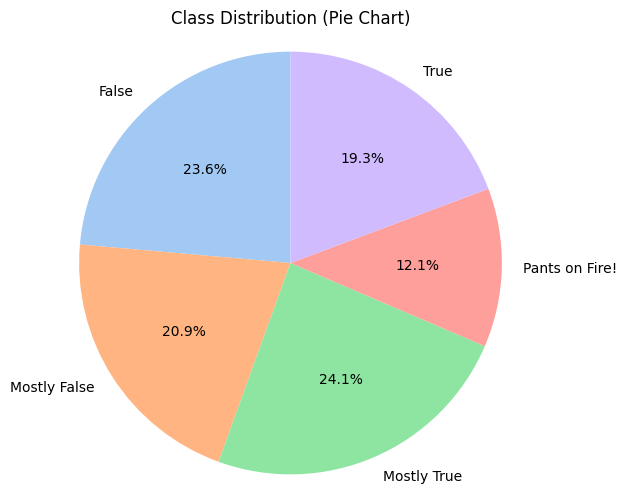


Sample Statements from Each Class:

Class False Samples:
['The Florida House is "holding the FINAL public hearing" of a controversial education bill in the middle of spring break..."when they hope (teachers) are not watching or listening."'
 '"Oprah tells Fox News host ‘all white people have to die.’"'
 'George Allen\xa0cast "the deciding vote"\xa0for the 2003\xa0Bush\xa0tax cuts.']

Class Mostly False Samples:
['"Since being elected, (Tom Barrett) has dumped 8.2 billion gallons of raw sewage into Lake Michigan."'
 '"We have asked public employees to pay 10 percent of the costs of their guaranteed pension and 15 percent of the cost of their health care. ... The leadership of those public employees unions don\'t want to pay anything."'
 "There is majority support for the Democrats' health care plans."]

Class Mostly True Samples:
['Says Hillary Clinton "supported North American Free Trade Agreement), and she supported China’s entrance into the World Trade Organization…. She supported t

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count class distribution
label_counts = df['veracity'].value_counts().sort_index()

# Pie chart
plt.figure(figsize=(6,6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
plt.title("Class Distribution (Pie Chart)")
plt.axis('equal')
plt.show()


label_counts = df['veracity'].value_counts().sort_index()

print("\nSample Statements from Each Class:")
for label in label_counts.index:
    print(f"\nClass {label} Samples:")
    print(df[df['veracity'] == label]['statement'].sample(3, random_state=42).values)



In [4]:
# 5. إعداد RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

class TruthDataset(Dataset):
    def __init__(self, texts, labels, max_length=256):
        self.texts = texts
        self.labels = labels
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels.iloc[idx]
        encoding = tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = TruthDataset(X_train, y_train)
test_dataset = TruthDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [5]:
# 6. Model setup using RoBERTa
model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

# 7. Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

# Move model to device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)



Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


(…)eb5afc8b2b397fe5e04beabb9b1ef355255ade81:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [6]:
# 8. Training with tracking of training and validation accuracy and loss
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for batch in tqdm(train_loader, desc=f'Training Epoch {epoch+1}'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_accuracy = train_correct / train_total
    avg_train_loss = train_loss / len(train_loader)

    # Evaluation on validation set
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_accuracy = val_correct / val_total
    avg_val_loss = val_loss / len(test_loader)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}")


Training Epoch 1: 100%|██████████| 560/560 [06:18<00:00,  1.48it/s]


Epoch 1/3
Train Loss: 0.6487 | Train Accuracy: 0.6291
Validation Loss: 0.5986 | Validation Accuracy: 0.6863


Training Epoch 2: 100%|██████████| 560/560 [06:23<00:00,  1.46it/s]


Epoch 2/3
Train Loss: 0.5875 | Train Accuracy: 0.6904
Validation Loss: 0.5830 | Validation Accuracy: 0.6881


Training Epoch 3: 100%|██████████| 560/560 [06:23<00:00,  1.46it/s]


Epoch 3/3
Train Loss: 0.5024 | Train Accuracy: 0.7520
Validation Loss: 0.6798 | Validation Accuracy: 0.6685


In [7]:

# Early Stopping class
class EarlyStopping:
    def __init__(self, patience=3, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0


In [8]:
# 10. Evaluation
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)[:, 1]  # Probability for positive class
        _, predicted = torch.max(logits, 1)

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Calculate metrics
binary_metrics = {
    'accuracy': accuracy_score(all_labels, all_preds),
    'precision': precision_score(all_labels, all_preds, zero_division=0),
    'recall': recall_score(all_labels, all_preds, zero_division=0),
    'f1': f1_score(all_labels, all_preds, zero_division=0),
    'roc_auc': roc_auc_score(all_labels, all_probs)
}

# Print metrics
print(f"\nTest Accuracy: {100 * correct / total:.2f}%")
print("Binary Classification Metrics:")
print(f"Accuracy: {binary_metrics['accuracy']:.4f}")
print(f"Precision: {binary_metrics['precision']:.4f}")
print(f"Recall: {binary_metrics['recall']:.4f}")
print(f"F1 Score: {binary_metrics['f1']:.4f}")
if 'roc_auc' in binary_metrics:
    print(f"ROC-AUC: {binary_metrics['roc_auc']:.4f}")


Test Accuracy: 66.85%
Binary Classification Metrics:
Accuracy: 0.6685
Precision: 0.5948
Recall: 0.7645
F1 Score: 0.6690
ROC-AUC: 0.7467


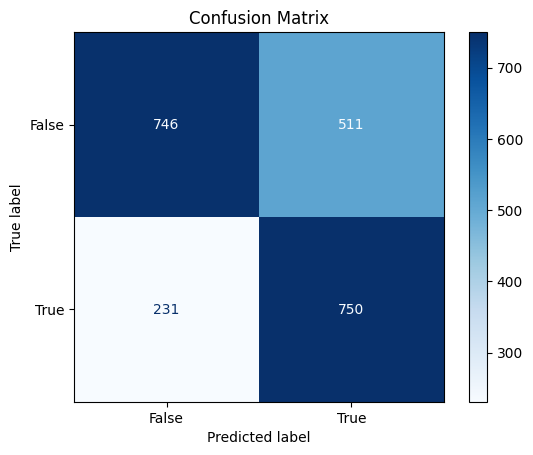

In [9]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve # Import roc_curve here

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['False', 'True'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

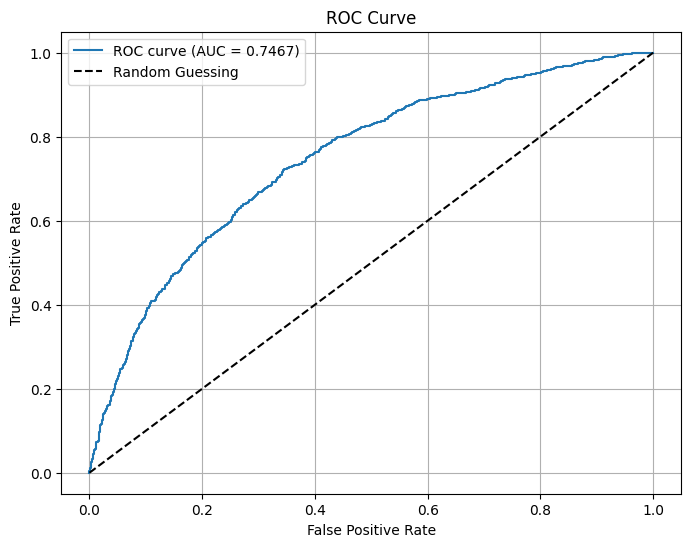

In [10]:
# 16. ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_score(all_labels, all_probs):.4f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()